In [1]:
def Static_Model(edges, weights, nodes, source, destination):

    from pyqubo import Array,Constraint,Placeholder
    
    x = Array.create(name = 'x', shape =len(edges), vartype = 'BINARY') 

    i = 0
    fcost = 0
    for i in range(len(edges)):
        fcost += (weights[i]*x[i]) ## Put the expression for constraints in

    p = 27
    node=1
    while(node<=nodes):
        sum = 0
        for j in range(len(edges)):
            if edges[j][0] == node: ##Outgoing from the current node
                sum += x[j]
            elif edges[j][1] == node: ##Incoming into the current node
                sum -= x[j]

        if node == source:
            sum -= 1
        elif node== destination:
            sum += 1

        fcost += p*((sum)**2)
        node+=1

    model = fcost.compile()

    linear, quadratic, offset = model.to_ising()

    # general imports
    import numpy as np
    import matplotlib.pyplot as plt
    # magic word for producing visualizations in notebook
    get_ipython().run_line_magic('matplotlib', 'inline')
    import string
    import time

    # AWS imports: Import Braket SDK modules
    from braket.circuits import Circuit, Gate, Observable
    from braket.devices import LocalSimulator
    from braket.aws import AwsDevice, AwsQuantumTask


    # In[28]:


    def create_circuit(beta, gamma):
        ## initializing the initial qubit state with H gates ##
        circuit = Circuit()
        n_qubits = len(edges)

        for qubit in range(n_qubits):
            circuit.h(qubit)

        ## Implementing the problem Hamiltonian ##
        for qubit in range(n_qubits):
            linear_coeff = linear.get('x['+str(qubit)+']')
            circuit = circuit.rz(qubit, -1*linear_coeff)

        #Algorithmic method to add the ZZ gates - CHECK TO SEE IF IT AFFECTS THE RESULTS(it should'nt because they commute)
        for i in range(len(quadratic)):
            qubit_1 = int(list(quadratic.keys())[i][0][2])
            qubit_2 = int(list(quadratic.keys())[i][1][2])

            quadratic_coeff = quadratic.get(('x['+str(qubit_1)+']', 'x['+str(qubit_2)+']'))

            circuit.zz(qubit_1, qubit_2, quadratic_coeff*gamma)

        ## Implementing the Mixer Hamiltonian ##
        for qubit in range(n_qubits):
            circuit.rx(qubit, 2*beta) # theta=2*beta because rx rotates the qubit about X by theta/2 angle

        return circuit


    # * <b>Remember that there are 3 parameters that can be varied - beta, gamma and penalty p </b>

    # In[29]:


    ## Expectation value of the Hamiltonian is basically the expected cost value which we can get from an average of the
    ## cost values over all states that have occurred ##
    def compute_expectation(counts, shots):

        expectation = 0
        sum = 0
        states = list(counts.keys())
        for i in range(len(states)):
            state = states[i] # string variable of the current qubit states
            state_cost = 0
            for j in range(len(state)): # Convention of the states is that the left-most qubit is the first qubit q0
                state_cost = state_cost + int(state[j])*weights[j]

            expectation = expectation + state_cost*counts.get(state)

        expectation /= 1000
        return expectation


    # In[30]:


    ## Now we measure the circuit ##
    def expectation_execute_circuit(param):
        ## Set up the device to run the circuit
        device = LocalSimulator()

        ## QAOA parameters to be optimized such that the eigenvalue Cost(β, γ) can be minimized ##
        beta = param[0]
        gamma = param[1]

        circuit = create_circuit(beta, gamma)

        shots = 1000
        result = device.run(circuit, shots).result()
        counts = result.measurement_counts

        return compute_expectation(counts, shots)    


    # In[31]:


    ## Classical Optimizer ##

    from scipy.optimize import minimize

    res = minimize(expectation_execute_circuit,
                   [1.0, 1.0],
                   method='COBYLA')

    # ## Analyzing the Results

    # In[32]:


    beta = res.get('x')[0]
    gamma = res.get('x')[1]
    circuit = create_circuit(beta, gamma)

    device = LocalSimulator()
    result = device.run(circuit, shots = 1000).result()
    counts = result.measurement_counts

    # plot using Counter
    #plt.bar(counts.keys(), counts.values())
    #plt.xlabel('bitstrings')
    #plt.ylabel('counts')


    # ## Post-Processing
    # 
    # Remove the output states that are not possible (among the top ten most probable states) and then check for the most probable states.
    # Check for joined paths, that is check that if a path enum ending with a number exists, then another path enum starting with the same number also exists, unless its a source or destination. They should always be 1.

    # In[33]:


    def check_state(s):

        ## Firstly check if the path starts from a source and ends at a destination
        source_flag = False
        destination_flag = False
        multiple_branches = False
        continuity_flag = True

        starting_nodes = []
        ending_nodes = []

        ## Check to see if the source and destination nodes exist in the network
        i=0
        for i in range(len(s)):
            if(s[i] == '1'):

                if(edges[i][0] == source):
                    source_flag = True
                if(edges[i][1] == destination):
                    destination_flag = True

                starting_nodes += [edges[i][0]]
                ending_nodes += [edges[i][1]]

        ## Now check if a node repeats itself in starting or ending_nodes. If yes, set multiple_branches
        i = 0
        for i in range(len(starting_nodes)):
            cnt1 = starting_nodes.count(starting_nodes[i])
            cnt2 = ending_nodes.count(ending_nodes[i])
            if cnt1 > 1 or cnt2 > 1:
                multiple_branches = True
                break


        ## Then iteratively go through ending nodes and check if the same node exists in the next starting_nodes index                
        ## This is an easier check for continuity and necessarily requires the edges nodes to be in some order
        ## Also go with the thumb rule that the destination node will be the last value of ending_nodes
        for i in range(len(ending_nodes)-1):
            if starting_nodes[i+1] != ending_nodes[i]:
                continuity_flag = False
                break

        if source_flag and destination_flag and continuity_flag and (not multiple_branches):
            return True
        else:
            return False

    states = list(counts.keys())
    possible_states = []
    i = 0
    for i in range(len(states)):
        s = states[i]
        flag = check_state(s)
        if flag:
            possible_states += [s]

    del states

    i = 0
    for i in range(len(possible_states)):
        print(possible_states[i]+':'+str(counts[possible_states[i]]))
        
    # print(counts)

    return counts

## Approximation Ratio Benchmarking on AWS State Vector Simulator

We are going to be collecting data on the Approximation Ratio over the number of qubits for the simulator.
Approximation ratio is defined as the ratio of the cost of the path from the optimization algorithm over the cost of the true most efficient path.

In this experiment we run the simulation 5 times and take an average of the approximation ratio over the 5 runs.

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import random

### 3 Qubits

#### 3a

{(1, 2): Text(0.0, -0.3333333333333333, '3'),
 (1, 3): Text(-0.5, 0.1666666666666667, '10'),
 (2, 3): Text(0.5, 0.1666666666666667, '5')}

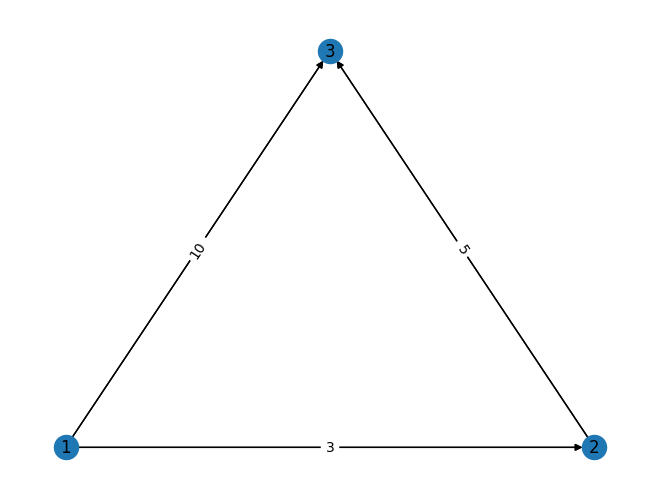

In [3]:
edges = [(1,2), (1,3), (2,3)]
weights = [3, 10, 5]

G = nx.DiGraph()
G.add_nodes_from([1,2,3])

pos = nx.planar_layout(G)

for i in range(len(edges)):
    G.add_edge(*edges[i], weight=weights[i])

nodes = G.number_of_nodes()
source = 1
destination = 3

nx.draw(G, pos, with_labels=True)
nx.draw_networkx_edges(G, pos, arrows=True)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

In [4]:
final_states = Static_Model(edges, weights, nodes, source, destination)

101:715


In [5]:
print(final_states)

Counter({'101': 715, '100': 222, '111': 30, '001': 16, '011': 8, '110': 7, '000': 2})


Approx Ratio = 1

#### 3b

{(1, 2): Text(0.11111111111111116, -0.3333333333333333, '2'),
 (2, 3): Text(0.5555555555555556, 0.11111111111111113, '3'),
 (3, 4): Text(-0.1111111111111111, 0.33333333333333337, '4')}

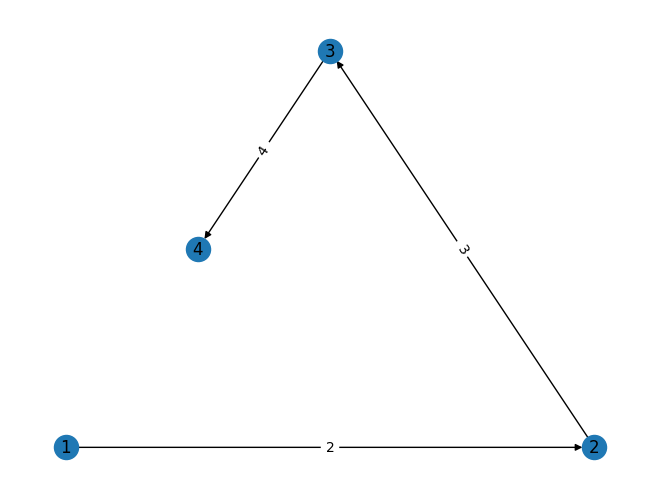

In [6]:
edges = [(1,2), (2,3), (3,4)]
weights = [2, 3, 4]

G = nx.DiGraph()
G.add_nodes_from([1,2,3,4])
pos = nx.planar_layout(G)

#pos=nx.get_node_attributes(G,'pos')

for i in range(len(edges)):
    G.add_edge(*edges[i], weight=weights[i])

nodes = G.number_of_nodes()
source = 1
destination = 4

nx.draw(G, pos, with_labels=True)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

In [7]:
final_states = Static_Model(edges, weights, nodes, source, destination)

111:60


#### 3c

{(1, 2): Text(0.0, -0.3333333333333333, '3'),
 (2, 3): Text(0.5, 0.1666666666666667, '4'),
 (3, 1): Text(-0.5, 0.1666666666666667, '5')}

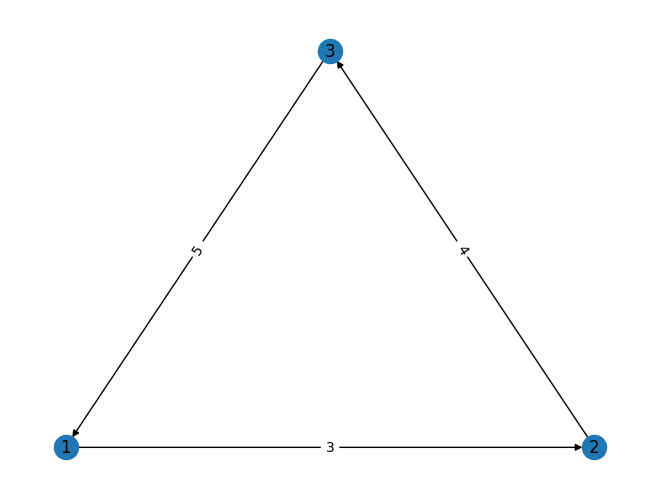

In [8]:
edges = [(1,2), (2,3), (3,1)]
weights = [3,4,5]

G = nx.DiGraph()
G.add_nodes_from([1,2,3])
pos = nx.planar_layout(G)

#pos=nx.get_node_attributes(G,'pos')

for i in range(len(edges)):
    G.add_edge(*edges[i], weight=weights[i])

nodes = G.number_of_nodes()
source = 1
destination = 1

nx.draw(G, pos, with_labels=True)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

In [9]:
final_states = Static_Model(edges, weights, nodes, source, destination)

111:74


### 4 Qubits

#### 4a

{(1, 2): Text(0.5, 0.5, '5'),
 (1, 3): Text(0.5, -0.5, '7'),
 (2, 4): Text(1.5, 0.5, '4'),
 (3, 4): Text(1.5, -0.5, '8')}

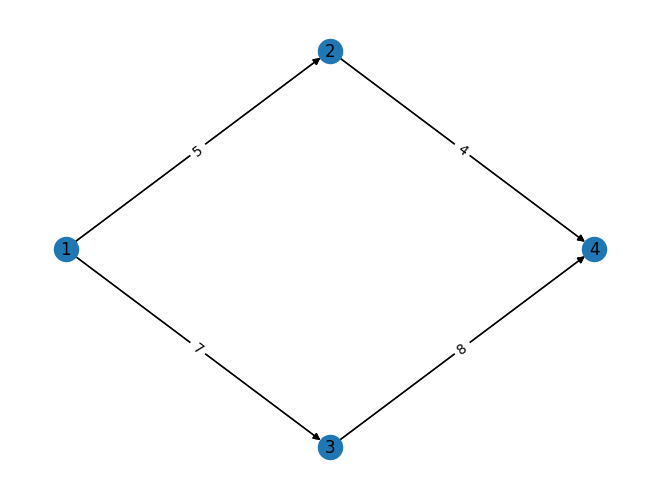

In [10]:
edges = [(1,2), (1,3), (2,4), (3,4)]
weights = [5, 7, 4, 8]

G = nx.DiGraph()
G.add_node(1, pos=(0,0))
G.add_node(2, pos=(1,1))
G.add_node(3, pos=(1,-1))
G.add_node(4, pos=(2,0))



pos = nx.get_node_attributes(G, 'pos')

for i in range(len(edges)):
    G.add_edge(*edges[i], weight=weights[i])

nodes = G.number_of_nodes()
source = 1
destination = 4

nx.draw(G, pos, with_labels=True)
nx.draw_networkx_edges(G, pos, arrows=True)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

In [11]:
final_states = Static_Model(edges, weights, nodes, source, destination)

1010:280
0101:119


#### 4b

{(1, 2): Text(0.5, 0.5, '5'),
 (1, 3): Text(0.5, -0.5, '7'),
 (2, 3): Text(1.0, 0.0, '1'),
 (3, 4): Text(1.5, -0.5, '8')}

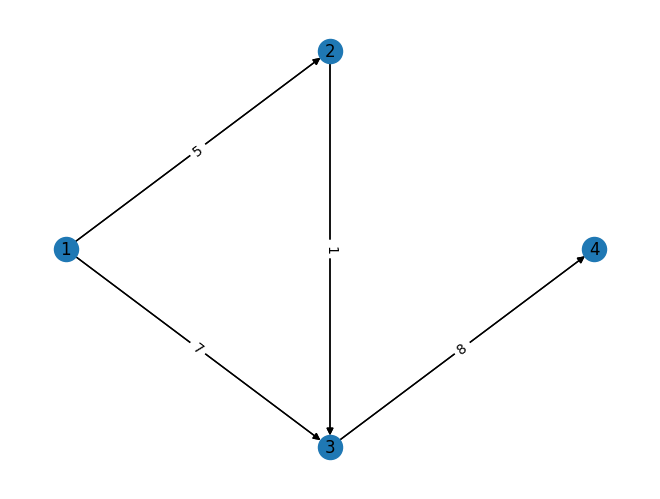

In [12]:
edges = [(1,2), (1,3), (2,3), (3,4)]
weights = [5, 7, 1, 8]

G = nx.DiGraph()
G.add_node(1, pos=(0,0))
G.add_node(2, pos=(1,1))
G.add_node(3, pos=(1,-1))
G.add_node(4, pos=(2,0))

pos = nx.get_node_attributes(G, 'pos')

for i in range(len(edges)):
    G.add_edge(*edges[i], weight=weights[i])

nodes = G.number_of_nodes()
source = 1
destination = 4

nx.draw(G, pos, with_labels=True)
nx.draw_networkx_edges(G, pos, arrows=True)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

In [13]:
final_states = Static_Model(edges, weights, nodes, source, destination)

1011:33
0101:15


### 5 Qubits

#### 5a

In [14]:
edges = [(1,2), (1,3), (2,4), (4,5), (3,5)]
weights = [1,4,2,3,4]

G = nx.DiGraph()
G.add_node(1, pos=(0,0))
G.add_node(2, pos=(1,1))
G.add_node(3, pos=(2,-1))
G.add_node(4, pos=(3,1))
G.add_node(5, pos=(4,0))

pos = nx.get_node_attributes(G, 'pos')
#pos = nx.get_node_attributes(G, 'pos')

for i in range(len(edges)):
    G.add_edge(*edges[i], weight=weights[i])

nodes = G.number_of_nodes()
source = 1
destination = 5

In [15]:
final_states = Static_Model(edges, weights, nodes, source, destination)

01001:15
10110:15


Approx Ratio = 1.333

{(1, 2): Text(0.5, 0.5, '1'),
 (1, 3): Text(1.0, -0.5, '4'),
 (2, 4): Text(2.0, 1.0, '1'),
 (3, 5): Text(3.0, -0.5, '4'),
 (4, 3): Text(2.5, 0.0, '1')}

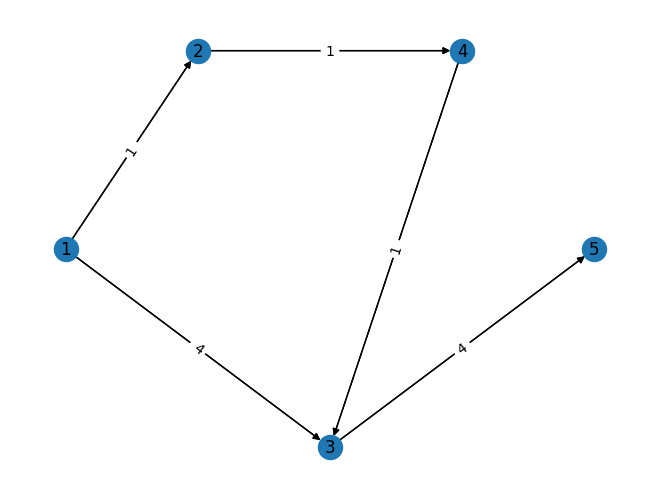

In [16]:
edges = [(1,2), (1,3), (2,4), (4,3), (3,5)]
weights = [1,4,1,1,4]

G = nx.DiGraph()
G.add_node(1, pos=(0,0))
G.add_node(2, pos=(1,1))
G.add_node(3, pos=(2,-1))
G.add_node(4, pos=(3,1))
G.add_node(5, pos=(4,0))

pos = nx.get_node_attributes(G, 'pos')
#pos = nx.get_node_attributes(G, 'pos')

for i in range(len(edges)):
    G.add_edge(*edges[i], weight=weights[i])

nodes = G.number_of_nodes()
source = 1
destination = 5

nx.draw(G, pos, with_labels=True)
nx.draw_networkx_edges(G, pos, arrows=True)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

In [17]:
final_states = Static_Model(edges, weights, nodes, source, destination)

01001:65
10111:13


Approximation Ratio = 1.142

### 6 Qubits

#### 6a

{(1, 2): Text(0.5, 0.5, '1'),
 (1, 3): Text(0.5, -0.5, '4'),
 (2, 4): Text(1.5, 1.0, '2'),
 (3, 5): Text(1.5, -1.0, '3'),
 (4, 6): Text(2.5, 0.5, '4'),
 (5, 6): Text(2.5, -0.5, '6')}

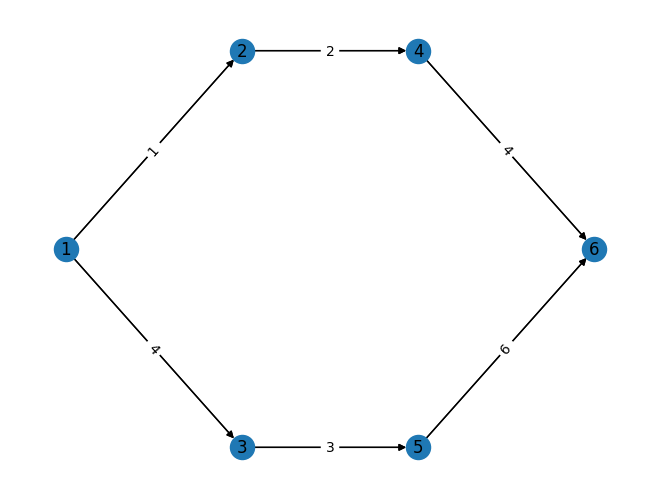

In [18]:
edges = [(1,2), (1,3), (2,4), (3,5), (4, 6), (5, 6)]
weights = [1,4,2,3,4,6]

G = nx.DiGraph()
G.add_node(1, pos=(0,0))
G.add_node(2, pos=(1,1))
G.add_node(3, pos=(1,-1))
G.add_node(4, pos=(2,1))
G.add_node(5, pos=(2,-1))
G.add_node(6 ,pos=(3,0))

pos = nx.get_node_attributes(G, 'pos')
#pos = nx.get_node_attributes(G, 'pos')

for i in range(len(edges)):
    G.add_edge(*edges[i], weight=weights[i])

nodes = G.number_of_nodes()
source = 1
destination = 6

nx.draw(G, pos, with_labels=True)
nx.draw_networkx_edges(G, pos, arrows=True)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

In [19]:
final_states = Static_Model(edges, weights, nodes, source, destination)

010101:8
101010:1


Approximation Ratio = 1.171428571428571

{(1, 2): Text(0.5, 0.5, '1'),
 (1, 3): Text(0.5, -0.5, '4'),
 (2, 3): Text(1.0, 0.0, '2'),
 (2, 4): Text(1.5, 1.0, '3'),
 (3, 4): Text(1.5, 0.0, '4'),
 (4, 5): Text(2.5, 0.5, '6')}

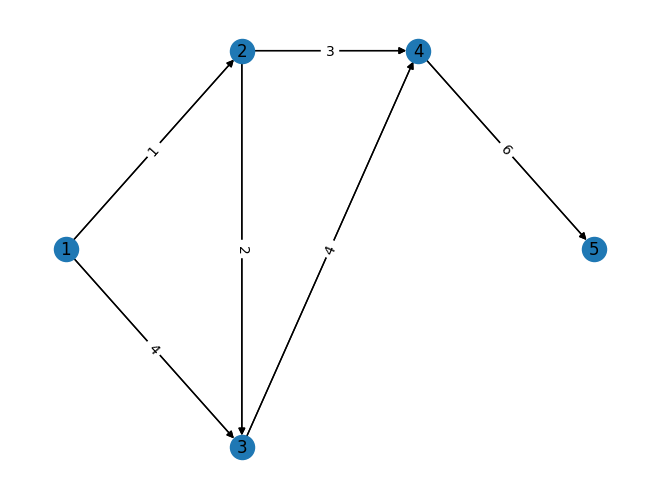

In [20]:
edges = [(1,2), (1,3), (2,3), (2,4), (3,4), (4,5)]
weights = [1,4,2,3,4,6]

G = nx.DiGraph()
G.add_node(1, pos=(0,0))
G.add_node(2, pos=(1,1))
G.add_node(3, pos=(1,-1))
G.add_node(4, pos=(2,1))
G.add_node(5 ,pos=(3,0))

pos = nx.get_node_attributes(G, 'pos')
#pos = nx.get_node_attributes(G, 'pos')

for i in range(len(edges)):
    G.add_edge(*edges[i], weight=weights[i])

nodes = G.number_of_nodes()
source = 1
destination = 5

nx.draw(G, pos, with_labels=True)
nx.draw_networkx_edges(G, pos, arrows=True)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

In [21]:
final_states = Static_Model(edges, weights, nodes, source, destination)
print(final_states)

101011:5
100101:8
010011:8
Counter({'010100': 75, '010000': 63, '011100': 48, '000100': 48, '011000': 45, '000000': 40, '100100': 37, '110100': 35, '001100': 29, '001000': 29, '101100': 27, '010110': 26, '111100': 25, '010010': 24, '111000': 24, '000110': 22, '011010': 21, '110000': 20, '000101': 20, '010101': 19, '000001': 17, '101000': 16, '011101': 14, '000010': 13, '101010': 13, '100000': 12, '100110': 12, '111110': 11, '001010': 11, '110110': 11, '001101': 10, '110101': 10, '111010': 10, '011001': 10, '010001': 9, '001110': 8, '100010': 8, '100101': 8, '010011': 8, '011110': 7, '101110': 7, '101101': 7, '110001': 6, '000111': 6, '001011': 6, '111101': 6, '100001': 6, '001001': 6, '101001': 6, '000011': 5, '111011': 5, '101011': 5, '001111': 5, '011011': 4, '111001': 4, '110010': 4, '111111': 4, '100111': 3, '011111': 3, '010111': 3, '101111': 2, '110111': 1, '110011': 1})


Approximation Ratio = 1

{(1, 2): Text(0.5, 0.5, '1'),
 (1, 3): Text(0.5, -0.5, '4'),
 (2, 3): Text(1.0, 0.0, '2'),
 (2, 4): Text(1.5, 1.0, '4'),
 (3, 2): Text(1.0, 0.0, '3'),
 (4, 5): Text(2.5, 0.5, '6')}

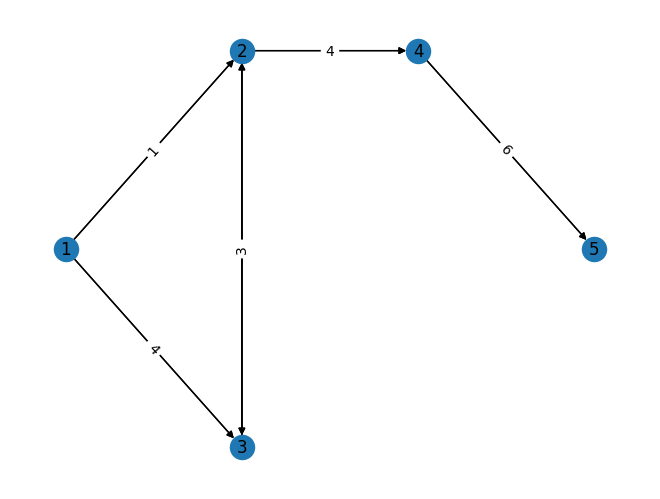

In [22]:
edges = [(1,2), (1,3), (2,3), (3,2), (2,4), (4,5)]
weights = [1,4,2,3,4,6]

G = nx.DiGraph()
G.add_node(1, pos=(0,0))
G.add_node(2, pos=(1,1))
G.add_node(3, pos=(1,-1))
G.add_node(4, pos=(2,1))
G.add_node(5 ,pos=(3,0))

pos = nx.get_node_attributes(G, 'pos')
#pos = nx.get_node_attributes(G, 'pos')

for i in range(len(edges)):
    G.add_edge(*edges[i], weight=weights[i])

nodes = G.number_of_nodes()
source = 1
destination = 5

nx.draw(G, pos, with_labels=True)
nx.draw_networkx_edges(G, pos, arrows=True)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

In [23]:
final_states = Static_Model(edges, weights, nodes, source, destination)
print(final_states)

010111:1
100011:1
Counter({'000000': 227, '010000': 170, '100000': 81, '110000': 72, '010100': 71, '000100': 61, '100100': 46, '110100': 33, '001000': 28, '000010': 22, '000001': 20, '100001': 17, '010001': 14, '011000': 13, '000101': 10, '010101': 10, '101000': 9, '100010': 9, '101100': 9, '010010': 8, '000011': 8, '000110': 8, '001100': 7, '110010': 5, '010110': 5, '100101': 4, '110001': 4, '010011': 3, '110110': 3, '001001': 3, '110111': 2, '110101': 2, '111000': 2, '101010': 2, '101001': 2, '111100': 1, '110011': 1, '011100': 1, '010111': 1, '100111': 1, '100110': 1, '011010': 1, '101110': 1, '100011': 1, '001010': 1})


Approximation Ratio = 1.218181818181818

{(1, 2): Text(0.5, 0.0, '1'),
 (2, 3): Text(1.5, 0.5, '4'),
 (2, 4): Text(1.5, -0.5, '2'),
 (3, 5): Text(2.5, 1.0, '3'),
 (4, 6): Text(3.0, -0.5, '6'),
 (5, 6): Text(3.5, 0.5, '4')}

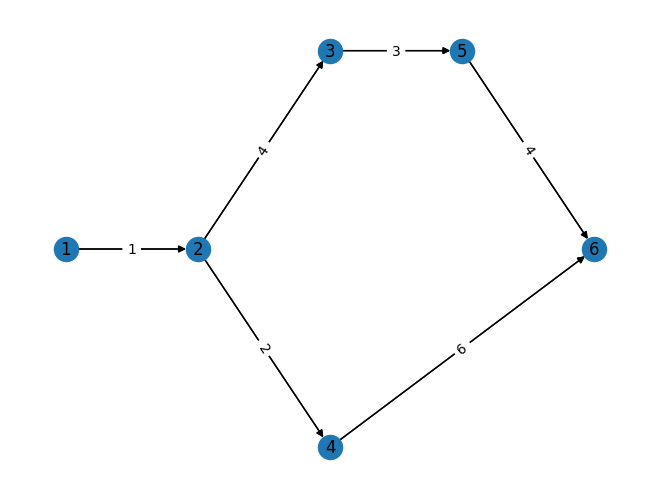

In [24]:
edges = [(1,2), (2,3), (2,4), (3,5), (5,6), (4,6)]
weights = [1,4,2,3,4,6]

G = nx.DiGraph()
G.add_node(1, pos=(0,0))
G.add_node(2, pos=(1,0))
G.add_node(3, pos=(2,1))
G.add_node(4, pos=(2,-1))
G.add_node(5 ,pos=(3,1))
G.add_node(6, pos=(4,0))

pos = nx.get_node_attributes(G, 'pos')
#pos = nx.get_node_attributes(G, 'pos')

for i in range(len(edges)):
    G.add_edge(*edges[i], weight=weights[i])

nodes = G.number_of_nodes()
source = 1
destination = 6

nx.draw(G, pos, with_labels=True)
nx.draw_networkx_edges(G, pos, arrows=True)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

In [25]:
final_states = Static_Model(edges, weights, nodes, source, destination)
print(final_states)

110110:7
101001:35
Counter({'100000': 252, '100001': 185, '110000': 161, '110001': 143, '101001': 35, '100010': 30, '110010': 28, '101000': 23, '000000': 19, '000001': 17, '110100': 13, '111001': 12, '100011': 11, '110101': 10, '110110': 7, '100100': 7, '110011': 6, '010000': 6, '100101': 6, '100111': 4, '110111': 3, '101010': 2, '100110': 2, '000010': 2, '101110': 2, '011001': 2, '010001': 2, '001001': 2, '111000': 1, '111100': 1, '101011': 1, '000101': 1, '001010': 1, '111101': 1, '101101': 1, '010111': 1})


Approximation Ratio = 1. This network can be used to prove that if the optimal path is very much lesser in cost than the next optimal path, approx ratio will be mostly 1 due to how likely it would be.

### 7 Qubits

{(1, 2): Text(0.5, 0.0, '1'),
 (1, 3): Text(0.0, -0.5, '4'),
 (2, 4): Text(1.5, 0.0, '2'),
 (3, 5): Text(0.5, -1.0, '3'),
 (4, 7): Text(3.0, 0.0, '6'),
 (5, 6): Text(1.5, -1.0, '4'),
 (6, 7): Text(3.0, -0.5, '1')}

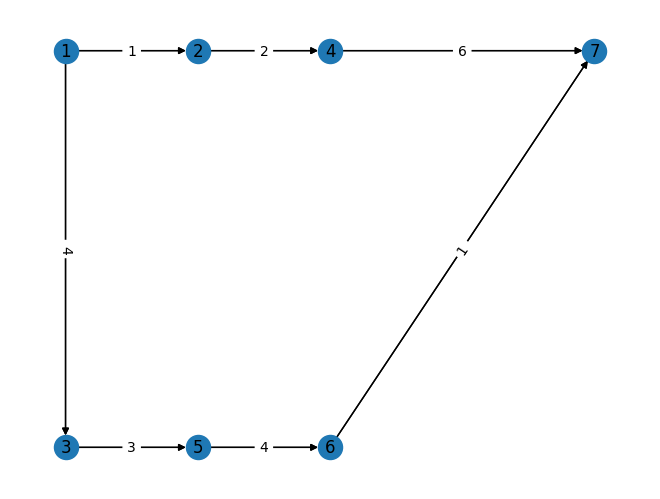

In [26]:
edges = [(1,2), (1,3), (2,4), (3,5), (5,6), (4,7), (6,7)]
weights = [1,4,2,3,4,6,1]

G = nx.DiGraph()
G.add_node(1, pos=(0,0))
G.add_node(2, pos=(1,0))
G.add_node(3, pos=(0,-1))
G.add_node(4, pos=(2,0))
G.add_node(5 ,pos=(1,-1))
G.add_node(6, pos=(2,-1))
G.add_node(7, pos=(4,0))

pos = nx.get_node_attributes(G, 'pos')
#pos = nx.get_node_attributes(G, 'pos')

for i in range(len(edges)):
    G.add_edge(*edges[i], weight=weights[i])

nodes = G.number_of_nodes()
source = 1
destination = 7

nx.draw(G, pos, with_labels=True)
nx.draw_networkx_edges(G, pos, arrows=True)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

In [27]:
final_states = Static_Model(edges, weights, nodes, source, destination)
print(final_states)

1010010:3
Counter({'0000000': 239, '0000010': 205, '1000000': 98, '0000001': 85, '0000011': 78, '1000010': 55, '0010000': 27, '1000001': 25, '1000011': 24, '0010010': 17, '0000100': 16, '0000110': 16, '0100000': 12, '0010001': 11, '1010000': 11, '0100010': 9, '0010011': 6, '1000100': 6, '1100010': 5, '0000111': 5, '1100011': 5, '1010011': 4, '1100000': 4, '1010001': 4, '1000111': 3, '1010010': 3, '1100001': 3, '0110010': 3, '0011010': 2, '0000101': 2, '1001000': 2, '1000101': 2, '1001010': 2, '1000110': 2, '0100001': 2, '0001011': 1, '0100100': 1, '1110010': 1, '0010110': 1, '1010100': 1, '0010100': 1, '1001011': 1})


Approximation Ratio was easily = 1

{(1, 2): Text(0.5, 0.0, '1'),
 (1, 3): Text(0.0, -0.5, '1'),
 (2, 4): Text(1.5, 0.0, '2'),
 (3, 5): Text(0.5, -1.0, '3'),
 (4, 7): Text(3.0, 0.0, '6'),
 (5, 6): Text(1.5, -1.0, '1'),
 (6, 7): Text(3.0, -0.5, '1')}

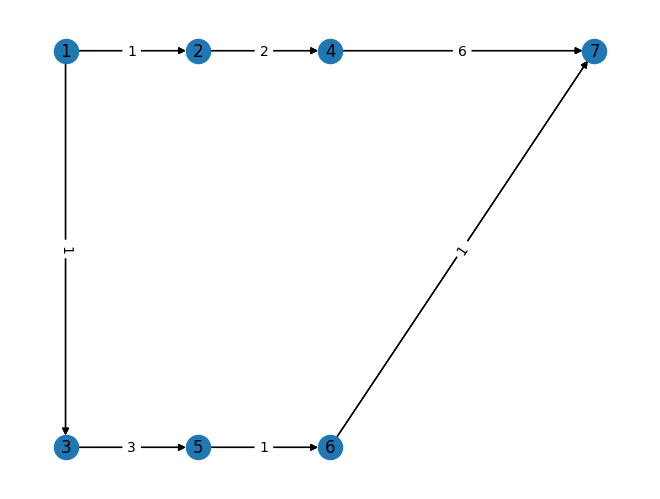

In [28]:
edges = [(1,2), (1,3), (2,4), (3,5), (5,6), (4,7), (6,7)]
weights = [1,1,2,3,1,6,1]

G = nx.DiGraph()
G.add_node(1, pos=(0,0))
G.add_node(2, pos=(1,0))
G.add_node(3, pos=(0,-1))
G.add_node(4, pos=(2,0))
G.add_node(5 ,pos=(1,-1))
G.add_node(6, pos=(2,-1))
G.add_node(7, pos=(4,0))

pos = nx.get_node_attributes(G, 'pos')
#pos = nx.get_node_attributes(G, 'pos')

for i in range(len(edges)):
    G.add_edge(*edges[i], weight=weights[i])

nodes = G.number_of_nodes()
source = 1
destination = 7

nx.draw(G, pos, with_labels=True)
nx.draw_networkx_edges(G, pos, arrows=True)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

In [29]:
final_states = Static_Model(edges, weights, nodes, source, destination)
print(final_states)

1010010:4
Counter({'0000000': 142, '0000010': 108, '0000001': 68, '0100000': 57, '1000000': 53, '0000011': 47, '0000110': 43, '0000100': 39, '0100010': 35, '1000010': 31, '1000001': 26, '0000101': 23, '0010000': 22, '0100001': 20, '1100000': 18, '0000111': 17, '0010010': 17, '1000110': 17, '0100011': 17, '0100100': 14, '1000011': 14, '1100010': 14, '1000100': 13, '0100110': 12, '1100110': 10, '0010100': 9, '1100011': 9, '0110010': 8, '1100001': 8, '0010001': 7, '0100101': 6, '0001000': 6, '0010110': 5, '1100100': 5, '1000111': 4, '1010010': 4, '0100111': 4, '0010111': 3, '0110110': 3, '0110100': 3, '1010000': 3, '1010110': 3, '1000101': 3, '0110000': 3, '0001010': 2, '1110001': 2, '1110000': 2, '1010001': 2, '0001001': 2, '0001011': 2, '0001100': 1, '0110001': 1, '0110101': 1, '1110010': 1, '1100101': 1, '1110110': 1, '0010011': 1, '1010111': 1, '0111010': 1, '0011010': 1, '1010011': 1, '1001010': 1, '1011000': 1, '1001001': 1, '1010101': 1})


Approximation Ratio = 1.5 , never was the true optimal path chosen. Maybe the network prefers to traverse through lesser edges, over the cost. 

{(1, 2): Text(0.5, 0.0, '5'),
 (1, 3): Text(0.0, -0.5, '1'),
 (2, 4): Text(1.5, 0.0, '5'),
 (3, 5): Text(0.5, -1.0, '3'),
 (4, 7): Text(3.0, 0.0, '6'),
 (5, 6): Text(1.5, -1.0, '1'),
 (6, 7): Text(3.0, -0.5, '1')}

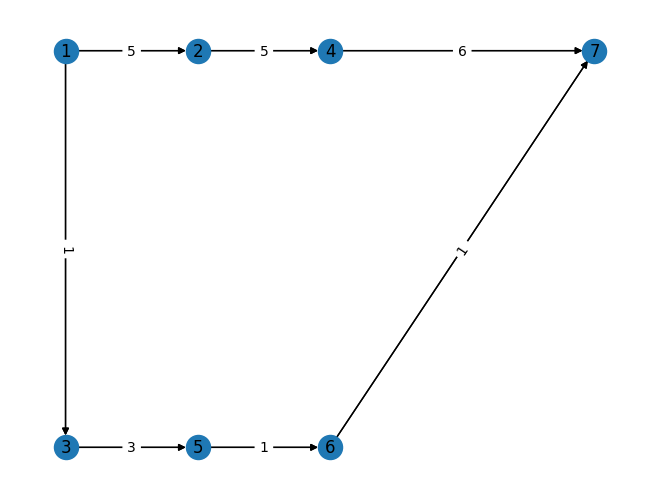

In [30]:
edges = [(1,2), (1,3), (2,4), (3,5), (5,6), (4,7), (6,7)]
weights = [5,1,5,3,1,6,1]

G = nx.DiGraph()
G.add_node(1, pos=(0,0))
G.add_node(2, pos=(1,0))
G.add_node(3, pos=(0,-1))
G.add_node(4, pos=(2,0))
G.add_node(5 ,pos=(1,-1))
G.add_node(6, pos=(2,-1))
G.add_node(7, pos=(4,0))

pos = nx.get_node_attributes(G, 'pos')
#pos = nx.get_node_attributes(G, 'pos')

for i in range(len(edges)):
    G.add_edge(*edges[i], weight=weights[i])

nodes = G.number_of_nodes()
source = 1
destination = 7

nx.draw(G, pos, with_labels=True)
nx.draw_networkx_edges(G, pos, arrows=True)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

In [31]:
final_states = Static_Model(edges, weights, nodes, source, destination)
print(final_states)

1010010:15
Counter({'0000000': 96, '0000010': 71, '0100000': 56, '0000001': 46, '1000000': 43, '0000100': 43, '0100010': 34, '0000011': 33, '0010000': 33, '1000010': 28, '0000110': 26, '0010010': 22, '0100100': 21, '0100001': 19, '0000101': 17, '0010001': 17, '1010010': 15, '0001000': 13, '0100110': 13, '0000111': 13, '0110010': 13, '1100000': 13, '1000001': 13, '1000011': 12, '0010100': 11, '0100111': 11, '0010011': 11, '1000100': 10, '0100011': 10, '0001001': 9, '0010110': 9, '1100010': 8, '1010000': 8, '1100001': 8, '0110001': 8, '0010111': 8, '0110000': 8, '1000101': 8, '1010100': 7, '0101000': 7, '1010001': 6, '1110001': 6, '0110011': 6, '0110110': 6, '1000110': 6, '0110100': 6, '1100011': 6, '0100101': 6, '0001010': 5, '1110000': 4, '0010101': 4, '1100110': 4, '0011000': 4, '0110111': 4, '1100101': 4, '0101010': 3, '0001100': 3, '1000111': 3, '0011010': 3, '1110110': 3, '1001001': 3, '0110101': 3, '1010110': 3, '1100100': 3, '1001100': 3, '1001010': 3, '1110011': 2, '0111001': 2,

Approximation Ratio = 2.333 , still the true optimal path showed up only once.

### 8 Qubits

{(1, 2): Text(0.8535533883976804, 0.3535533936135803, '5'),
 (1, 3): Text(0.4999999913068337, 0.5000000052158999, '1'),
 (2, 4): Text(2.632505458066703e-08, 0.7071067688487334, '5'),
 (3, 5): Text(-0.4999999823681117, 0.49999996150451276, '3'),
 (4, 6): Text(-0.7071067539475732, 4.8180748835058296e-08, '1'),
 (5, 7): Text(-0.499999954549978, -0.5000000121704327, '6'),
 (6, 8): Text(-6.308191025095056e-08, -0.7071067618942005, '1'),
 (7, 8): Text(0.3535533479180046, -0.8535534032988418, '4')}

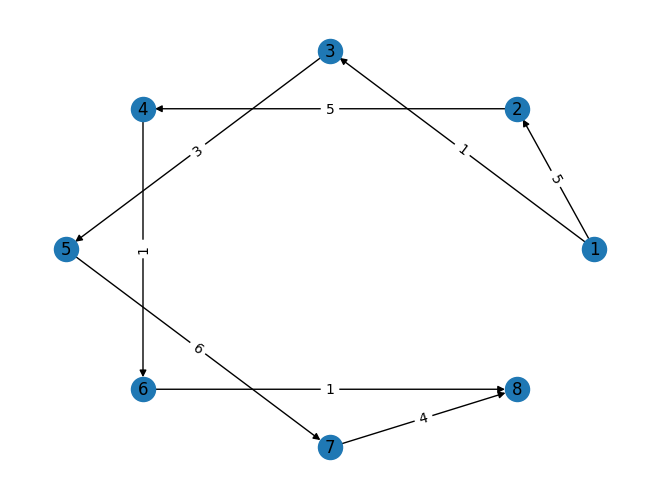

In [32]:
edges = [(1,2), (1,3), (2,4), (3,5), (4,6), (5,7), (6,8), (7,8)]
weights = [5,1,5,3,1,6,1,4]

G = nx.DiGraph()
G.add_nodes_from([1,2,3,4,5,6,7,8])
pos = nx.circular_layout(G)

#pos=nx.get_node_attributes(G,'pos')

for i in range(len(edges)):
    G.add_edge(*edges[i], weight=weights[i])

nodes = G.number_of_nodes()
source = 1
destination = 8

nx.draw(G, pos, with_labels=True)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

In [33]:
final_states = Static_Model(edges, weights, nodes, source, destination)
print(final_states)

10101010:3
Counter({'00000000': 89, '00000100': 88, '00100000': 41, '10000000': 39, '00100100': 38, '00000010': 37, '01000000': 36, '00000110': 30, '10000100': 30, '01000100': 26, '00001100': 25, '00001000': 25, '00001010': 18, '01001100': 18, '00100010': 16, '11000000': 14, '01000010': 14, '10000110': 14, '00101000': 13, '00101100': 12, '00100110': 12, '00001110': 11, '01000110': 11, '00000001': 11, '10000010': 11, '10100100': 11, '01100100': 11, '01100000': 11, '00000011': 10, '10001100': 10, '01001000': 8, '11000100': 8, '10001000': 8, '00101110': 8, '11001000': 7, '01001010': 7, '00000101': 6, '00101010': 6, '10001010': 6, '01001110': 6, '01100010': 6, '01100110': 5, '11001110': 5, '00001001': 5, '10000001': 5, '10000011': 5, '01010000': 5, '10001110': 5, '01010100': 4, '01101010': 4, '11000010': 4, '01000011': 4, '01000001': 4, '00100001': 4, '00011000': 4, '01101000': 3, '11000001': 3, '10000101': 3, '01101100': 3, '10100000': 3, '01110000': 3, '01101001': 3, '10001001': 3, '1110

Approximation Ratio = 1 (although some runs did not give any viable path)

## Modularization of Networkx ##

In [34]:
def create_directed_graph_(edges_with_weights):
    # Create a directed graph
    graph = nx.DiGraph()

    # Add edges with weights
    for edge, weight in edges_with_weights.items():
        source, target = edge
        graph.add_edge(source, target, weight=weight)

    # Draw the graph
    pos = nx.spring_layout(graph, seed=42)  # You can change the layout algorithm
    labels = nx.get_edge_attributes(graph, 'weight')
    nx.draw(graph, pos, with_labels=True)
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)
    plt.show()
    print(source,target)


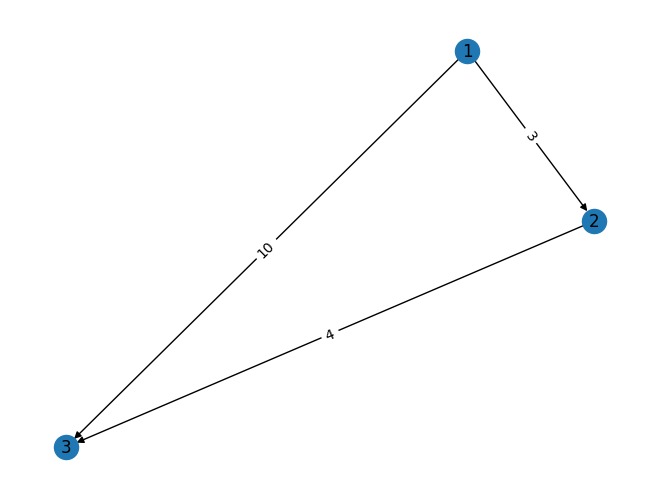

1 3


In [35]:
edges_and_weights = {(1,2):3,(2,3):4,(1,3):10}
create_directed_graph_(edges_and_weights)

In [147]:
def create_directed_graph(edges, weights, source, destination):
    if len(edges) != len(weights):
        raise ValueError("Edges and weights lists must have the same length.")

    # Create a directed graph
    graph = nx.DiGraph()

    # Add edges with weights
    for i in range(len(edges)):
        graph.add_edge(*edges[i], weight=weights[i])

    # Define colors for nodes
    node_colors = {node: 'red' if node == source else ('lightgreen' if node == destination else 'blue') for node in graph.nodes}

    # Draw the graph
    pos = nx.spring_layout(graph, seed=random.randint(1, 100))  # You can change the layout algorithm
    labels = nx.get_edge_attributes(graph, 'weight') 
    nx.draw(graph, pos, with_labels=True, node_color=[node_colors[node] for node in graph.nodes])
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)
    plt.show()

    # Find the most efficient path using Dijkstra's algorithm
    shortest_path = nx.shortest_path(graph, source=source, target=destination, weight='weight')
    shortest_path_length = nx.shortest_path_length(graph, source=source, target=destination, weight='weight')

    print(f"The most efficient path from {source} to {destination} is: {shortest_path}")
    print(f"The length of the path is: {shortest_path_length}")

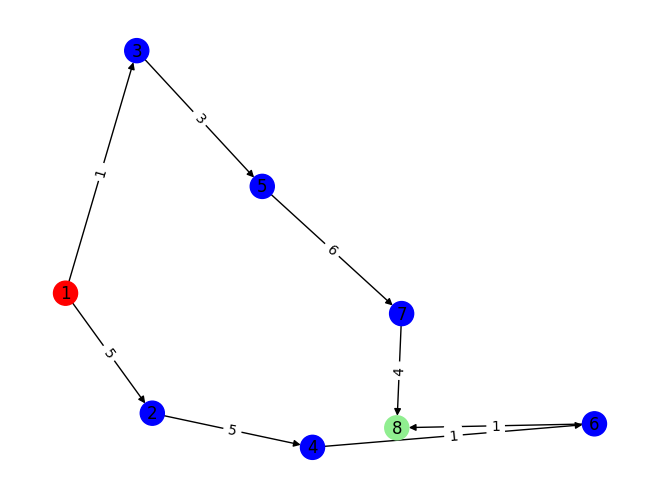

The most efficient path from 1 to 8 is: [1, 2, 4, 6, 8]
The length of the path is: 12


In [148]:
edges = [(1,2), (1,3), (2,4), (3,5), (4,6), (5,7), (6,8), (7,8)]
weights = [5,1,5,3,1,6,1,4]
source = 1
target = 8
create_directed_graph(edges, weights, source, target)

## Using Dijkstra Algorithm to classically find the optimized Path ##
### The algorithm is inbuilt in Networkx ###

In [66]:
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Define the edges and weights
edges_and_weights = {
    ('A', 'B'): 5,
    ('B', 'C'): 4,
    ('C', 'D'): 2,
    ('A', 'D'): 11,
}

# Add edges with weights to the graph
for edge, weight in edges_and_weights.items():
    G.add_edge(edge[0], edge[1], weight=weight)

# Source and destination nodes
source = 'A'
destination = 'D'

# Find the most efficient path using Dijkstra's algorithm
shortest_path = nx.shortest_path(G, source=source, target=destination, weight='weight')
shortest_path_length = nx.shortest_path_length(G, source=source, target=destination, weight='weight')

print(f"The most efficient path from {source} to {destination} is: {shortest_path}")
print(f"The length of the path is: {shortest_path_length}")

The most efficient path from A to D is: ['A', 'D']
The length of the path is: 11


# Random Generation of Networks #
## Uni-directional ##

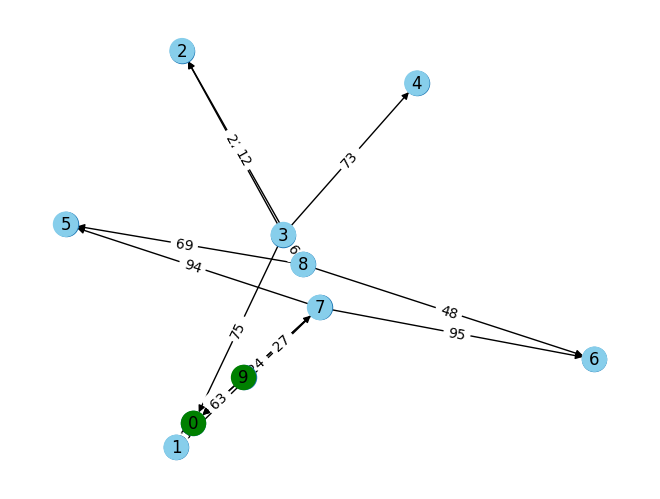

In [32]:
import networkx as nx
import random
import matplotlib.pyplot as plt

# Specify the number of nodes and edge density factor
num_nodes = 10
num_edges = random.randint(num_nodes,num_nodes*(num_nodes-1)/2)

# Create an empty directed graph (DiGraph)
G = nx.DiGraph()

# Add nodes to the graph
G.add_nodes_from(range(num_nodes))

# Add random weighted directed edges to the graph while avoiding self-loops
for _ in range(num_edges):
    source_node = random.randint(0, num_nodes - 1)
    destination_node = random.randint(0, num_nodes - 1)
    
    # Avoid self-loops (edges connecting a node to itself)
    while source_node == destination_node:
        destination_node = random.randint(0, num_nodes - 1)
    
    weight = random.randint(1, 100)
    G.add_edge(source_node, destination_node, weight=weight)

# Assign specific source and destination nodes
source_node = 0
destination_node = 9

# Create a layout for the nodes (e.g., spring layout)
layout = nx.spring_layout(G)

# Draw the directed graph with edge labels
nx.draw(G, pos=layout, with_labels=True)
edge_labels = {(u, v): d['weight'] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=edge_labels)

# Highlight the source and destination nodes
node_colors = ['green' if node == source_node or node == destination_node else 'skyblue' for node in G.nodes()]
nx.draw_networkx_nodes(G, pos=layout, node_color=node_colors)

# Show the plot
plt.show()


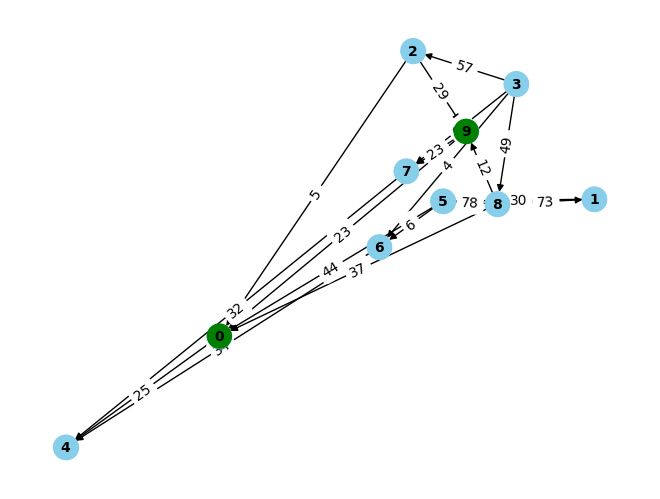

In [33]:
import networkx as nx
import random
import matplotlib.pyplot as plt

# Specify the number of nodes and edge density factor
num_nodes = 10
edge_density_factor = 0.3  # Adjust this factor as needed (between 0 and 1)

# Calculate the number of edges based on the density factor
num_edges = int(edge_density_factor * (num_nodes * (num_nodes - 1)))

# Create an empty directed graph (DiGraph)
G = nx.DiGraph()

# Add nodes to the graph
G.add_nodes_from(range(num_nodes))

# Create a set to track added edges
added_edges = set()

# Add random weighted directed edges to the graph while avoiding bidirectional paths and self-loops
for _ in range(num_edges):
    source_node = random.randint(0, num_nodes - 1)
    destination_node = random.randint(0, num_nodes - 1)
    
    # Avoid self-loops (edges connecting a node to itself)
    while source_node == destination_node:
        destination_node = random.randint(0, num_nodes - 1)
    
    edge = (source_node, destination_node)
    reverse_edge = (destination_node, source_node)
    
    # Check if the edge or its reverse already exists
    if edge not in added_edges and reverse_edge not in added_edges:
        weight = random.randint(1,100)
        G.add_edge(source_node, destination_node, weight=weight)
        added_edges.add(edge)

# Assign specific source and destination nodes
source_node = 0
destination_node = 9

# Create a layout for the nodes (e.g., spring layout)
layout = nx.spring_layout(G)

# Draw the directed graph with edge labels
nx.draw(G, pos=layout, with_labels=True, node_size=300, node_color='skyblue', font_size=10, font_color='black', font_weight='bold')
edge_labels = {(u, v): d['weight'] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=edge_labels)

# Highlight the source and destination nodes
node_colors = ['green' if node == source_node or node == destination_node else 'skyblue' for node in G.nodes()]
nx.draw_networkx_nodes(G, pos=layout, node_size=300, node_color=node_colors)

# Show the plot
plt.show()


## Bi-directional ##

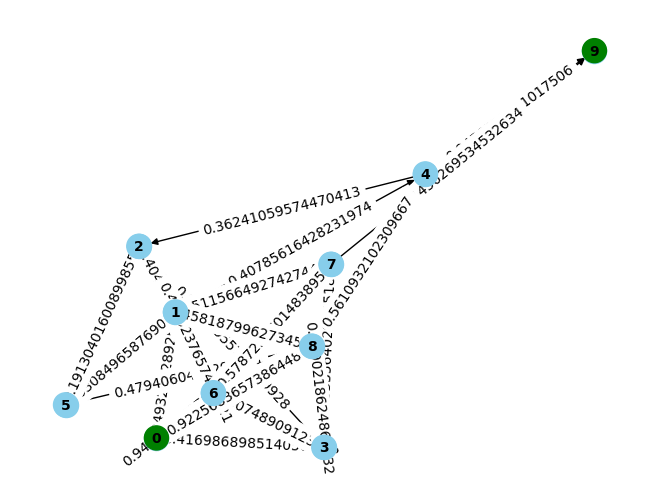

List of Edges (as two-tuple list):
[(3, 2), (8, 0), (0, 6), (6, 3), (5, 8), (4, 2), (8, 1), (1, 4), (6, 0), (0, 1), (7, 9), (8, 1), (8, 3), (4, 8), (4, 9), (8, 4), (3, 0), (2, 5), (3, 2), (3, 7), (6, 2), (7, 9), (6, 1), (1, 5), (0, 3), (7, 1), (7, 6)]
List of Weights:
[0.2562738705474038, 0.9225683657386448, 0.3583088023043741, 0.6220748909123252, 0.4794060434293441, 0.36241059574470413, 0.5814259685336303, 0.40785616428231974, 0.9422093737084815, 0.8049321028925099, 0.5325990529679362, 0.4581879962734502, 0.6690218624864532, 0.6320530507031201, 0.9456591461017506, 0.5610932102309667, 0.4169868985140561, 0.19130401600899855, 0.12447955766499928, 0.14553356402971518, 0.40424238359527764, 0.1456269534532634, 0.4815237657464121, 0.7030849658769075, 0.23737430980672866, 0.5115664927427447, 0.5787256701483895]


In [34]:
import networkx as nx
import random
import matplotlib.pyplot as plt

# Specify the number of nodes and edge density factor
num_nodes = 10
edge_density_factor = 0.3  # Adjust this factor as needed (between 0 and 1)

# Calculate the number of edges based on the density factor
num_edges = int(edge_density_factor * (num_nodes * (num_nodes - 1)))

# Create an empty directed graph (DiGraph)
G = nx.DiGraph()

# Add nodes to the graph
G.add_nodes_from(range(num_nodes))

# Initialize lists to store edges and weights
edges_list = []
weights_list = []

# Add random weighted directed edges to the graph while avoiding self-loops
for _ in range(num_edges):
    source_node = random.randint(0, num_nodes - 1)
    destination_node = random.randint(0, num_nodes - 1)
    
    # Avoid self-loops (edges connecting a node to itself)
    while source_node == destination_node:
        destination_node = random.randint(0, num_nodes - 1)
    
    weight = random.uniform(0.1, 1.0)
    G.add_edge(source_node, destination_node, weight=weight)
    
    # Append the edge as a two-tuple and its weight to the respective lists
    edges_list.append((source_node, destination_node))
    weights_list.append(weight)

# Assign specific source and destination nodes
source_node = 0
destination_node = 9

# Create a layout for the nodes (e.g., spring layout)
layout = nx.spring_layout(G)

# Draw the directed graph with edge labels
nx.draw(G, pos=layout, with_labels=True, node_size=300, node_color='skyblue', font_size=10, font_color='black', font_weight='bold')
edge_labels = {(u, v): d['weight'] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=edge_labels)

# Highlight the source and destination nodes
node_colors = ['green' if node == source_node or node == destination_node else 'skyblue' for node in G.nodes()]
nx.draw_networkx_nodes(G, pos=layout, node_size=300, node_color=node_colors)

# Show the plot
plt.show()

# Return the list of edges and weights
print("List of Edges (as two-tuple list):")
print(edges_list)
print("List of Weights:")
print(weights_list)


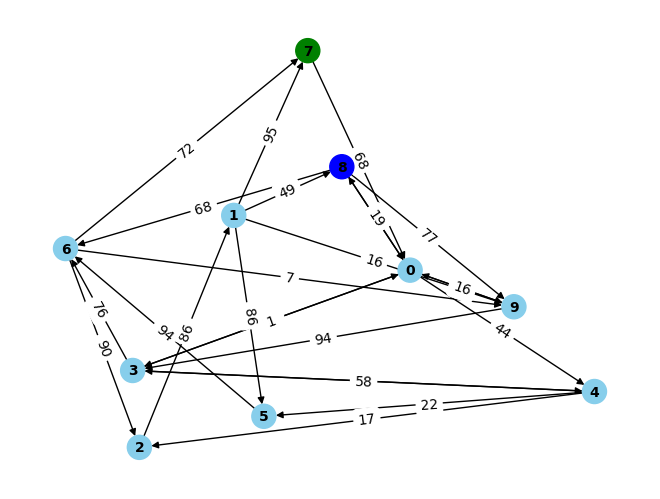

List of Edges (as two-tuple list):
[(8, 9), (6, 2), (8, 9), (7, 0), (4, 2), (4, 5), (4, 3), (9, 0), (3, 0), (1, 8), (2, 1), (5, 6), (8, 6), (6, 9), (0, 4), (6, 9), (1, 9), (1, 7), (3, 4), (1, 5), (8, 0), (9, 3), (0, 3), (0, 9), (2, 1), (4, 2), (0, 8), (6, 7), (3, 6)]
List of Weights:
[3, 90, 77, 68, 5, 22, 58, 16, 1, 49, 7, 94, 68, 78, 44, 7, 16, 95, 20, 86, 19, 94, 52, 19, 86, 17, 90, 72, 76]
Source Node: 7
Destination Node: 8


In [43]:
import networkx as nx
import random
import matplotlib.pyplot as plt

def generate_random_bidirectional_graph_with_nodes_and_colors(num_nodes):
    """
    Generate a random bidirectional graph with automated source and destination nodes and colors.
    
    Args:
        num_nodes (int): Number of nodes in the graph.
        edge_density_factor (float): Edge density factor (between 0 and 1).

    Returns:
        nx.DiGraph: The generated directed graph.
        list of tuples: List of edges as two-tuple list.
        list of floats: List of corresponding weights for each edge.
        int: Source node.
        int: Destination node.
    """
    # Calculate the number of edges based on the density factor
    num_edges = random.randint(num_nodes,num_nodes*(num_nodes-1)/2)

    # Create an empty directed graph (DiGraph)
    G = nx.DiGraph()

    # Add nodes to the graph
    G.add_nodes_from(range(num_nodes))

    # Initialize lists to store edges and weights
    edges_list = []
    weights_list = []

    # Add random weighted directed edges to the graph while avoiding self-loops
    for _ in range(num_edges):
        source_node = random.randint(0, num_nodes - 1)
        destination_node = random.randint(0, num_nodes - 1)

        # Avoid self-loops (edges connecting a node to itself)
        while source_node == destination_node:
            destination_node = random.randint(0, num_nodes - 1)

        weight = random.randint(0,100)
        G.add_edge(source_node, destination_node, weight=weight)

        # Append the edge as a two-tuple and its weight to the respective lists
        edges_list.append((source_node, destination_node))
        weights_list.append(weight)

    # Assign automated source and destination nodes
    source_node = random.randint(0, num_nodes - 1)
    destination_node = random.randint(0, num_nodes - 1)
    
    # Ensure source and destination nodes are different
    while source_node == destination_node:
        destination_node = random.randint(0, num_nodes - 1)
    
    return G, edges_list, weights_list, source_node, destination_node

# Example usage:
num_nodes = 10
G, edges_list, weights_list, source_node, destination_node = generate_random_bidirectional_graph_with_nodes_and_colors(num_nodes)

# Create a color mapping for nodes
node_colors = ['green' if node == source_node else 'blue' if node == destination_node else 'skyblue' for node in G.nodes()]

# Visualize the graph with node colors (optional)
layout = nx.spring_layout(G)
nx.draw(G, pos=layout, with_labels=True, node_size=300, node_color=node_colors, font_size=10, font_color='black', font_weight='bold')
edge_labels = {(u, v): d['weight'] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=edge_labels)
plt.show()

# Print the generated lists and nodes
print("List of Edges (as two-tuple list):")
print(edges_list)
print("List of Weights:")
print(weights_list)
print("Source Node:", source_node)
print("Destination Node:", destination_node)


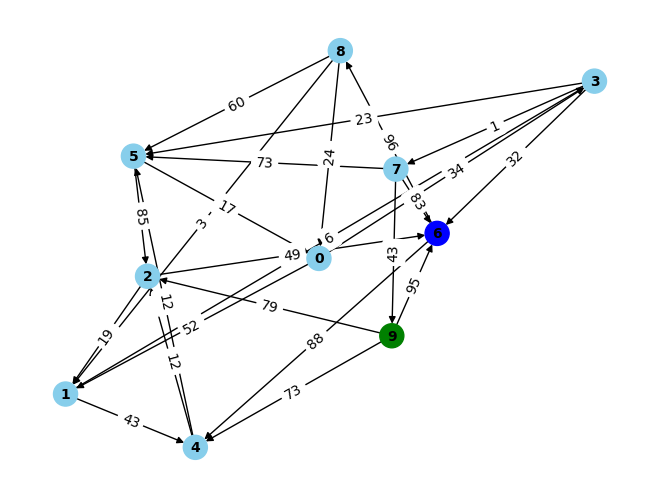

List of Edges (as two-tuple list):
[(3, 5), (8, 5), (6, 4), (2, 6), (9, 4), (9, 2), (9, 6), (0, 3), (5, 2), (6, 8), (7, 6), (8, 0), (1, 4), (7, 5), (4, 5), (8, 1), (5, 0), (7, 9), (2, 1), (4, 2), (1, 3), (3, 7), (0, 1), (3, 6)]
List of Weights:
[23, 60, 88, 49, 73, 79, 95, 34, 85, 96, 83, 24, 43, 73, 12, 3, 17, 43, 19, 12, 6, 1, 52, 32]
Source Node: 9
Destination Node: 6


In [46]:
import networkx as nx
import random
import matplotlib.pyplot as plt

def generate_random_unidirectional_graph_with_nodes_and_colors(num_nodes, edge_density_factor):
    """
    Generate a random unidirectional graph with automated source and destination nodes and colors.
    
    Args:
        num_nodes (int): Number of nodes in the graph.
        edge_density_factor (float): Edge density factor (between 0 and 1).

    Returns:
        nx.DiGraph: The generated directed graph.
        list of tuples: List of edges as two-tuple list.
        list of floats: List of corresponding weights for each edge.
        int: Source node.
        int: Destination node.
    """
    # Calculate the number of edges based on the density factor
    num_edges = int(edge_density_factor * (num_nodes * (num_nodes - 1)))

    # Create an empty directed graph (DiGraph)
    G = nx.DiGraph()

    # Add nodes to the graph
    G.add_nodes_from(range(num_nodes))

    # Initialize lists to store edges and weights
    edges_list = []
    weights_list = []

    # Create a list of all possible edge pairs
    edge_pairs = [(i, j) for i in range(num_nodes) for j in range(num_nodes) if i != j]

    # Shuffle the list of edge pairs
    random.shuffle(edge_pairs)

    # Add random weighted directed edges to the graph while avoiding bidirectional edges and self-loops
    for i in range(num_edges):
        source_node, destination_node = edge_pairs[i]

        # Avoid bidirectional edges and self-loops
        if not G.has_edge(destination_node, source_node):
            weight = random.randint(1, 100)

            # Add the edge to the graph
            G.add_edge(source_node, destination_node, weight=weight)

            # Append the edge as a two-tuple and its weight to the respective lists
            edges_list.append((source_node, destination_node))
            weights_list.append(weight)

    # Assign automated source and destination nodes
    source_node = random.randint(0, num_nodes - 1)
    destination_node = random.randint(0, num_nodes - 1)
    
    # Ensure source and destination nodes are different
    while source_node == destination_node:
        destination_node = random.randint(0, num_nodes - 1)

    if not nx.has_path(G, source_node, destination_node):
        # If there is no path, create an edge from source to destination
        weight = random.uniform(0.1, 1.0)
        G.add_edge(source_node, destination_node, weight=weight)
        edges_list.append((source_node, destination_node))
        weights_list.append(weight)

    return G, edges_list, weights_list, source_node, destination_node

# Example usage:
num_nodes = 10
edge_density_factor = 0.3

G, edges_list, weights_list, source_node, destination_node = generate_random_unidirectional_graph_with_nodes_and_colors(num_nodes, edge_density_factor)

# Create a color mapping for nodes
node_colors = ['green' if node == source_node else 'blue' if node == destination_node else 'skyblue' for node in G.nodes()]

# Visualize the graph with node colors (optional)
layout = nx.spring_layout(G)
nx.draw(G, pos=layout, with_labels=True, node_size=300, node_color=node_colors, font_size=10, font_color='black', font_weight='bold')
edge_labels = {(u, v): d['weight'] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=edge_labels)
plt.show()

# Print the generated lists and nodes
print("List of Edges (as two-tuple list):")
print(edges_list)
print("List of Weights:")
print(weights_list)
print("Source Node:", source_node)
print("Destination Node:", destination_node)
